In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torchvision.ops import DeformConv2d
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from calflops import calculate_flops
work_path = "/home/re6125015/DeepL/images"
os.chdir(work_path)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # You can choose any seed value

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_npz_data(file_path):
    loaded = np.load(file_path)
    X = loaded['array1']  # Adjust 'array1' if your image data key is different
    y = loaded['array2']  # Adjust 'array2' if your label data key is different
    return X, y

X_train, y_train = load_npz_data('train.npz')
X_val, y_val = load_npz_data('val.npz')
X_test, y_test = load_npz_data('test.npz')

In [3]:
class NPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is torch.long

In [4]:
res = 84
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((res, res)),  # ResNet typically uses 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = NPZDataset(X_train, y_train, transform=transform)
val_dataset = NPZDataset(X_val, y_val, transform=transform)
test_dataset = NPZDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [5]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.se_block = SEBlock(in_channels)  # Include SE block

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width*height)
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)
        value = self.value_conv(x).view(batch_size, -1, width*height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        out = self.se_block(out)  # Apply SE block
        return out

class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.attention = SelfAttention(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se_block = SEBlock(in_channels)  # Include SE block

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        out = self.attention(out)
        out = self.se_block(out)  # Apply SE block
        out = out * 0.2 + residual
        return out

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)   # 7, 2, 3
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.hybrid_block = SelfAttention(64)
        self.rrdb_block = RRDB(64)
        self.transition_layer = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 50)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.hybrid_block(x)
        x = self.rrdb_block(x)
        x = self.relu(self.bn2(self.transition_layer(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
from torch import optim
# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = Model().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [7]:
batch_size = 16
input_shape = (batch_size, 3, 84, 84)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  212.88 K
fwd MACs:                                                               5.7569 GMACs
fwd FLOPs:                                                              11.6577 GFLOPS
fwd+bwd MACs:                                                           17.2708 GMACs
fwd+bwd FLOPs:                                                          34.973 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modu

/home/re6125015/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss: 1.7874 Train Acc: 48.18% Val Loss: 1.8736 Val Acc: 44.22%
Epoch 2: Train Loss: 1.7928 Train Acc: 48.22% Val Loss: 1.8645 Val Acc: 45.11%
Epoch 3: Train Loss: 1.7897 Train Acc: 48.43% Val Loss: 1.8713 Val Acc: 44.00%
Epoch 4: Train Loss: 1.7921 Train Acc: 48.23% Val Loss: 1.8814 Val Acc: 44.22%
Epoch 5: Train Loss: 1.7897 Train Acc: 48.29% Val Loss: 1.8835 Val Acc: 44.67%
Epoch 6: Train Loss: 1.7871 Train Acc: 48.36% Val Loss: 1.8811 Val Acc: 44.67%
Epoch 7: Train Loss: 1.7876 Train Acc: 48.47% Val Loss: 1.8823 Val Acc: 44.67%
Early stopping triggered.


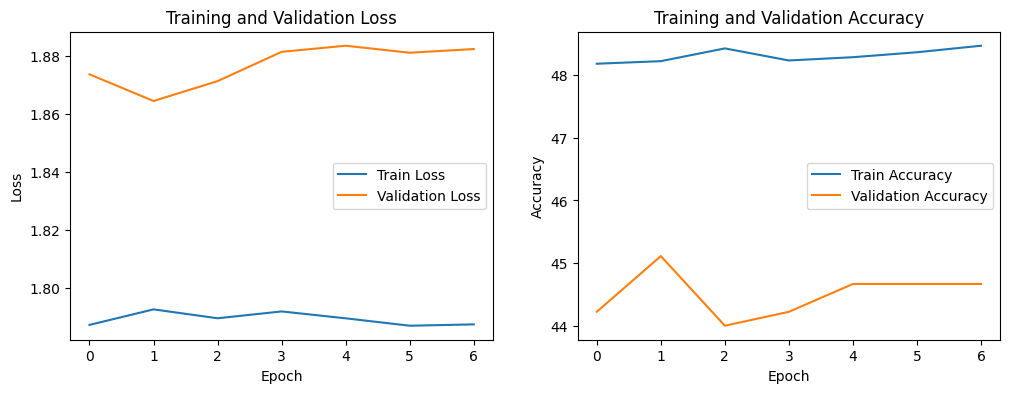

In [24]:
num_epochs = 50
early_stopping_counter = 0
best_val_loss = float('inf')

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_v2_{res}.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 4:  # Stops if no improvement after 4 epochs
        print("Early stopping triggered.")
        break

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [25]:
print(best_val_loss)

1.8644631077845892


In [26]:
model = Model()  # Ensure this matches the model architecture
model.load_state_dict(torch.load(f'best_model_v2_{res}.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the appropriate device (CPU or GPU)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (hybrid_block): SelfAttention(
    (query_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (se_block): SEBlock(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (rrdb_block): RRDB(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (a

In [27]:
# Function to make predictions and optionally evaluate the model
def predict(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_predictions = []
    all_labels = []  # Optional, only if labels are available in the test set

    with torch.no_grad():  # No need to track gradients for predictions
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # Optional

    return all_predictions, all_labels

# Get predictions and labels
predictions, labels = predict(model, test_loader)

In [28]:
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 50.00%


In [29]:
# Example of saving predictions to a CSV file
result_df = pd.DataFrame({'PredictedLabel': predictions})
result_df.to_csv(f'predict_v2_{res}.csv', index=False)

In [30]:
# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, predictions)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.19      0.33      0.24         9
           2       0.33      0.33      0.33         9
           3       0.50      0.56      0.53         9
           4       0.50      0.56      0.53         9
           5       0.50      0.44      0.47         9
           6       0.71      0.56      0.62         9
           7       0.57      0.44      0.50         9
           8       0.40      0.22      0.29         9
           9       0.22      0.22      0.22         9
          10       0.50      0.44      0.47         9
          11       0.33      0.22      0.27         9
          12       0.80      0.89      0.84         9
          13       0.25      0.44      0.32         9
          14       0.67      0.44      0.53         9
          15       0.50      0.44      0.47         9
          16       0.33      0.33      0.33         9
    

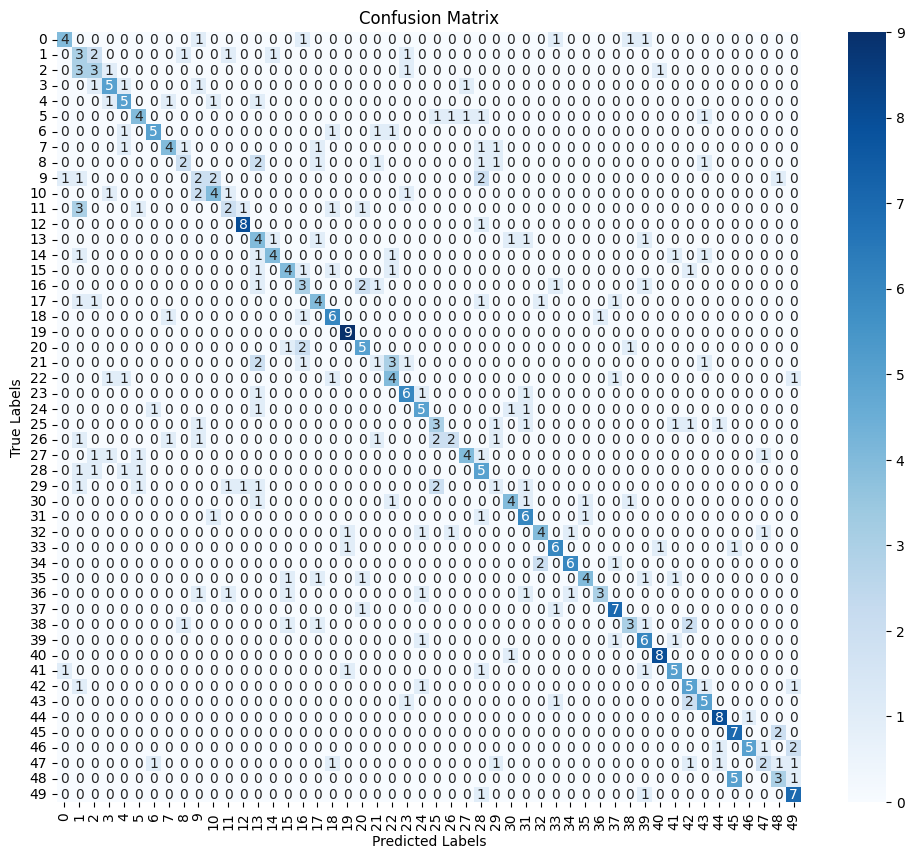

In [31]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()